## Data Generation for Flash Hit Time Detection Models
### First: multiple photons at the same time from a single point source

In [16]:
import sys
sys.path.append('..')

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from tqdm import tqdm, trange
import os
import pickle
from waveforms.make_waveform import BatchedLightSimulation

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sim = BatchedLightSimulation(cfg="../waveforms/templates/waveform_sim.yaml").to(device)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]


torch.Size([1, 16000])


Text(0, 0.5, 'Photon Count')

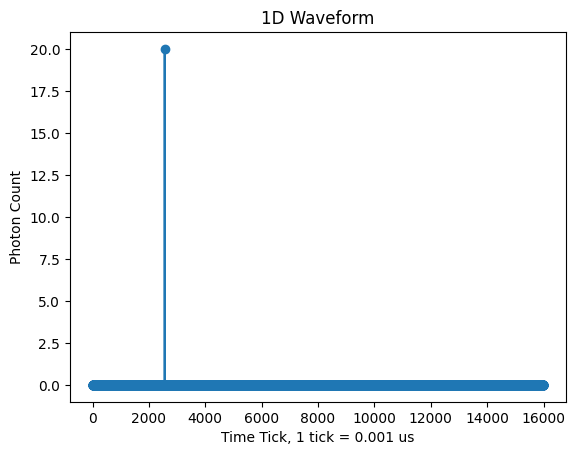

In [15]:
pmt_ids = torch.full((20,), 0) 
arrival_times = torch.zeros(20, dtype=torch.int64)
wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, n_pmts=1)
print(wf.shape)

ticks = np.arange(wf.shape[1])
plt.plot(ticks, wf.squeeze(0), marker='o')
plt.title("1D Waveform")
plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size} us")
plt.ylabel("Photon Count")

In [5]:
# Simulating with SiPM electronics convolution
# def forward(self, timing_dist: torch.Tensor, scintillation=True, tpb_delay=True, combined=True, jax=False):
output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
output = output.detach().cpu().numpy()
print(output)
print(type(output))

sipm response conv. time: 0.0781 sec
total forward time: 0.1102 sec
[-1.03985556e-07 -4.18134611e-08  6.10156761e-08 ...  5.99421455e-08
  5.95682725e-10  7.44695194e-09]
<class 'numpy.ndarray'>


Text(0, 0.5, 'Photon Count')

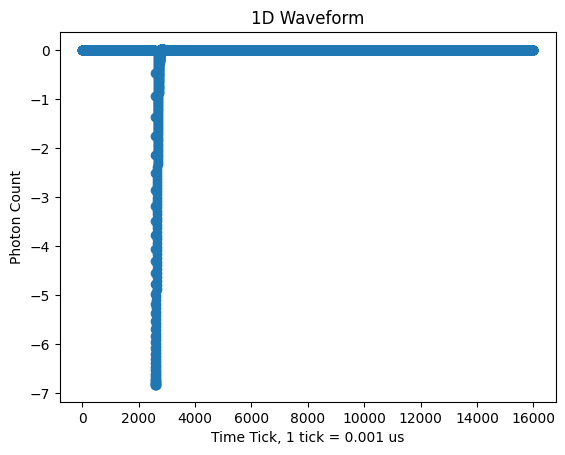

In [6]:
############### Plotting ############################
ticks = np.arange(wf.shape[1])
plt.plot(ticks, output, marker='o')
plt.title("1D Waveform")
plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size} us")
plt.ylabel("Photon Count")

### Actual Pipeline to Generate a Bunch of Waveforms

In [7]:
nphotons = np.random.randint(1, 1000, 10000)  # 100 random integers between 1 and 1000
arrival_times = np.random.uniform(0, 1, size=10000) * 1000  # 100 arrival times in [0, 100) ns, scaled to ps if needed

print(arrival_times)

[109.48206775 241.66195496 429.32766706 ...  78.3758305  668.07473003
 557.23895868]


In [ ]:
nphotons = np.random.randint(1, 1000, 10000)  # 100 random integers between 1 and 1000
all_arrival_times = np.random.uniform(0, 1, size=10000) * 6000  # in nanoseconds

sim_waveforms = []

for i, n in enumerate(nphotons):
    pmt_ids = torch.full((n,), 0, dtype=torch.int64)  # PMT 0 for all photons
    arrival_time = int(all_arrival_times[i])  # convert to int for torch.full
    arrival_times_tensor = torch.full((n,), arrival_time, dtype=torch.int64)

    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
    output = output.detach().cpu().numpy()
    sim_waveforms.append(output)

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = all_arrival_times

np.save("10k_flashes", data, allow_pickle=True)

Text(0.5, 1.0, '10000 1D Waveforms')

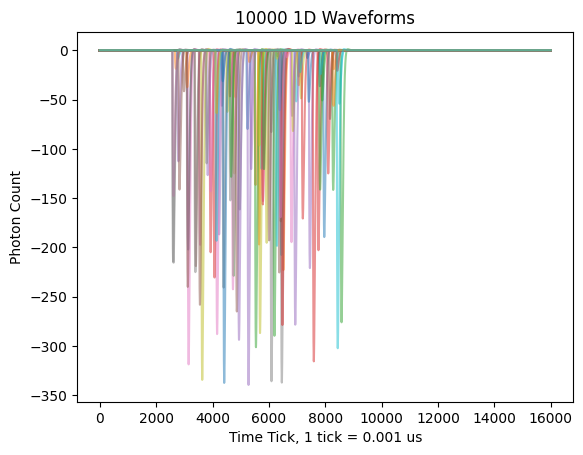

In [19]:
waveforms = np.load('10k_flashes.npy', allow_pickle=True).item()

for wf in waveforms['waveforms'][:100]:
    plt.plot(ticks, wf, alpha=0.5)
plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size} us")
plt.ylabel("Photon Count")
plt.title(f"{len(waveforms['waveforms'])} 1D Waveforms")